In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from obj_utils.io import load_obj, save_obj
from obj_utils.measure import *

from scipy.spatial import ConvexHull
from scipy.interpolate import interpolate

import matplotlib.pyplot as plt

from tqdm import tqdm
from numba import jit, njit

In [3]:
BELLYBUTTON_INDEX = 3500
GROIN_INDEX = 1208

In [4]:
vertices, faces = load_obj('/workspace/SilhouettesbasedHSE/output/sizekorea/20_M_0052/mesh_out.obj')
vertices[:, 1] -= vertices[:, 1].min()

In [5]:
bellybutton_y = vertices[BELLYBUTTON_INDEX, 1]
waist_plane = Plane.transverse(bellybutton_y)

v_inter, f_inter = get_intersecting_submesh(waist_plane, vertices, faces)
cc = get_connected_components(v_inter, f_inter)

v_waist, f_waist = max(cc, key=lambda x: x[0].shape)
v_waist_2d = v_waist[:, [0, 2]]

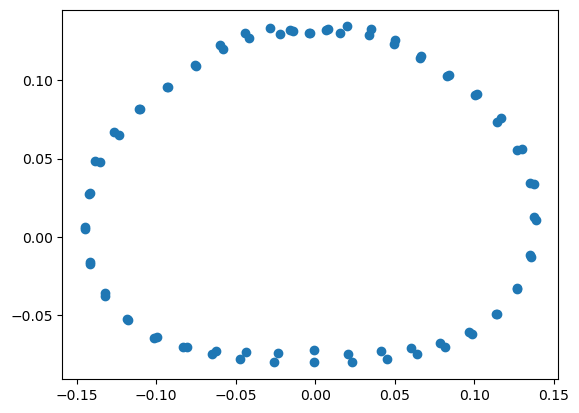

In [6]:
plt.scatter(*v_waist_2d.T)

In [7]:
# hull_idx = ConvexHull(v_waist_2d).vertices
# hull_waist = v_waist_2d[hull_idx]

# print(f'{get_loop_length(hull_waist)*100:.3f} cm')

# tck, _ = interpolate.splprep(hull_waist.T, s=0)
# inter_waist = interpolate.splev(np.linspace(0, 1, 1000), tck)

# inter_x = np.append(inter_waist[0], inter_waist[0][0])
# inter_y = np.append(inter_waist[1], inter_waist[1][0])

# plt.plot(inter_x, inter_y)
# plt.show()

In [8]:
def calculate_waist_length(v_smpl, f_smpl):
    """
    Calculate waist length 

    Arguments:
        - v_smpl SMPL vertices
        - f_smpl SMPL faces

    Return:
        - waist_length (m)
    """
    bellybutton_y = v_smpl[BELLYBUTTON_INDEX, 1]
    waist_plane = Plane.transverse(bellybutton_y)

    v_inter, f_inter = get_intersecting_submesh(waist_plane, v_smpl, f_smpl)
    cc = get_connected_components(v_inter, f_inter)

    v_waist, f_waist = max(cc, key=lambda x: x[0].shape)
    v_waist_2d = v_waist[:, [0, 2]]

    hull_idx = ConvexHull(v_waist_2d).vertices
    hull_waist = v_waist_2d[hull_idx]

    waist_length = get_loop_length(hull_waist)
    return waist_length

calculate_waist_length(vertices,faces) * 1000

796.7434802356457

In [9]:
def calculate_groin_height(v_smpl):
    """
    Calculate length from a floor to groin

    Arguments:
        - v_smpl SMPL vertices

    Return:
        - groin_y (m)
    """
    groin_y = v_smpl[GROIN_INDEX, 1]
    return groin_y

calculate_groin_height(vertices)

0.7811319999999999

In [10]:
def calculate_thighs_length(v_smpl, f_smpl, dy = 0.005):
    i = 1
    while True:
        groin_y = v_smpl[GROIN_INDEX, 1] - dy * i
        groin_plane = Plane.transverse(groin_y)

        v_inter, f_inter = get_intersecting_submesh(groin_plane, v_smpl, f_smpl)
        cc = get_connected_components(v_inter, f_inter)

        if len(cc) == 2:
            break
        i += 1

    thighs_v, _ = zip(*cc)
    thighs_v = sorted(thighs_v, key=lambda x: x[:, 0].min())
    thighs_2d = [t[:, [0, 2]] for t in thighs_v]

    thighs_length = []
    for v_2d in thighs_2d:
        hull_idx = ConvexHull(v_2d).vertices
        hull_waist = v_2d[hull_idx]

        length = get_loop_length(hull_waist)
        thighs_length.append(length)

    return thighs_length

calculate_thighs_length(vertices, faces)

[0.5966906869931164, 0.6062817349281466]

In [11]:
@jit(nopython=True)
def point_in_triangle(p, a, b, c):
    # Check if point p is inside the triangle formed by vertices a, b, and c.
    def sign(p1, p2, p3):
        return (p1[:, 0] - p3[:, 0]) * (p2[:, 1] - p3[:, 1]) - (p2[:, 0] - p3[:, 0]) * (p1[:, 1] - p3[:, 1])

    d1 = sign(p, a, b)
    d2 = sign(p, b, c)
    d3 = sign(p, c, a)
    
    has_neg = (d1 < 0) | (d2 < 0) | (d3 < 0)
    has_pos = (d1 > 0) | (d2 > 0) | (d3 > 0)
    
    return  ~(has_neg & has_pos)

In [61]:
from numba import int32, float64

@njit(int32(float64[:], float64[:],float64[:,:,:]))
def intersect_line_triangle(segment_start, segment_end, triangles_vertices):
    # Define the triangle vertices (a, b, and c).
    a = triangles_vertices[:,0,:]
    b = triangles_vertices[:,1,:]
    c = triangles_vertices[:,2,:]
    # Calculate the normal of the triangle.

    normal = np.cross(a - b,  c - a)

    # # Check if the line segment is parallel to the triangle plane.
    segment_direction = segment_end - segment_start
    # segment_normal_dot = np.einsum('p,bn->b', segment_direction, normal) TODO: replace einsum to other
    
    # if np.all(segment_normal_dot == 0):
    #     return False
    
    # non_zero = segment_normal_dot != 0
    # a = a[non_zero] - segment_start
    # segment_normal_dot = segment_normal_dot[non_zero]
    # normal = normal[non_zero]

    # num_non_zero = non_zero.sum()

    # t = np.einsum('bp,bn->b', a, normal) / segment_normal_dot

    # segment_start = np.broadcast_to(segment_start, (num_non_zero, 3))
    # segment_direction = np.broadcast_to(segment_direction, (num_non_zero, 3 ))
    
    # intersection_point = segment_start + t.reshape((-1,1)) * segment_direction
    
    # # # Check if the intersection point is inside the triangle.
    # return np.any(point_in_triangle(intersection_point, a, b, c))

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
Use of unsupported NumPy function 'numpy.einsum' or unsupported use of the function.

File "../../tmp/ipykernel_895799/3251216444.py", line 15:
<source missing, REPL/exec in use?>

During: typing of get attribute at /tmp/ipykernel_895799/3251216444.py (15)

File "../../tmp/ipykernel_895799/3251216444.py", line 15:
<source missing, REPL/exec in use?>


In [ ]:
@njit(float64[:,:](float64[:,:],int32[:,:]))
def floyd_warshall(vertices, faces):
    num_vertices = len(vertices)
    num_faces = len(faces)
    triangles_vertices = np.zeros((num_faces, 3, 3),dtype=np.float64)

    for i, f in enumerate(faces):
        for j, v in enumerate(f):
            triangles_vertices[i,j,:] = vertices[i,v]

    dist = np.full((num_vertices, num_vertices), np.inf)
    for k in range(num_vertices):
        for i in range(num_vertices):
            for j in range(num_vertices):
                p1 = vertices[i, :]
                p2 = vertices[j, :]
                
                intersect_line_triangle(p1,p2,triangles_vertices)
                # if not intersect_line_triangle(p1, p2, triangles_vertices):
                #     dist[i, j] = np.linalg.norm(p1 - p2)
                # elif dist[i,k] + dist[k,j] < dist[i,j]:
                #     dist[i,j] = dist[i,k] + dist[k,j]
                break
            break
        break
    return dist

In [ ]:
def calculate_biacromion_length(v_smpl, f_smpl):
    dist = floyd_warshall(v_smpl, f_smpl)
    # return dist[1821][5282]

calculate_biacromion_length(vertices[:100], faces)